In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os

from src.gans import Modifier
from src.search import AkiwiFeatureGenerator, ResnetFeatureGenerator, Search, CombinedSearch

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Load Search Models
Load Resnet and Akiwi50 features to retrieve with combined Resnet50 features.

In [2]:
folder_gens = {'akiwi_50': AkiwiFeatureGenerator(50), 
               'resnet': ResnetFeatureGenerator()}

In [3]:
dress_imgs = './data/images/fashion/dresses/'
model_imgs = './data/images/fashion_models/dresses_clustered/'

dress_feats = './data/features/fashion/dresses/'
model_feats = './data/features/fashion_models/dresses/'

In [4]:
dress_search = {}
for dir_name, gen in folder_gens.items():
    dress_search[dir_name] = Search(dress_imgs, os.path.join(dress_feats, dir_name), gen)

Loading features from: ./data/features/fashion/dresses/akiwi_50
Loading features from: ./data/features/fashion/dresses/resnet


In [5]:
model_search = {}
for dir_name, gen in folder_gens.items():
    model_search[dir_name] = Search(model_imgs, os.path.join(model_feats, dir_name), gen)

Loading features from: ./data/features/fashion_models/dresses/akiwi_50
Loading features from: ./data/features/fashion_models/dresses/resnet


In [6]:
# combined search
dress_resnet50 = CombinedSearch([dress_search['akiwi_50'], dress_search['resnet']], factors=[2, 1])
model_resnet50 = CombinedSearch([model_search['akiwi_50'], model_search['resnet']], factors=[2, 1])

# Modifications

In [7]:
modifier = Modifier('./data/models/')

In [8]:
def plot_img_row(images, img_labels=None):
    fig, axarr = plt.subplots(nrows=1, ncols=len(images), figsize=(len(images)*3, 4))
    
    for i, img in enumerate(images):
        ax = axarr[i]
        img = img.resize([256, 256])
        img = img.crop((40, 0, 216, 256))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        for spine in ax.spines.keys():
            ax.spines[spine].set_visible(False)
        
        if img_labels is not None:
            ax.set_title(img_labels[i])
        
    plt.show()

In [9]:
def ask_attr_input(input_name, available_attr):
    print("{}".format(input_name))
    print('-' * 20)
    print("Choose from the following: {}".format(list(available_attr)))
    print("or press ENTER to skip")
    attr = input()
    print()

    if attr != '':
        assert attr in available_attr, "Invalid attribute"

    return attr
    
def ask_value_input(available_values):
    print("Choose from the following: \n{}".format(available_values))
    value = input()
    print()
    assert value in available_values, "Invalid attribute value"

    return value

def plot_img(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    return img

In [10]:
def GAN_search(input_img):
    output_img = input_img
    plot_img(output_img)
    
    # SHAPE MODIFICATION
    shape_attrs = modifier._shape_modifier.LABELS
    attr = ask_attr_input('SHAPE MODIFICATION', list(shape_attrs.keys()))
    
    if attr != '':
        value = ask_value_input(shape_attrs[attr])
        output_img = modifier.modify_shape(output_img, attr, value)
        plot_img(output_img)
    

    # PATTERN MODIFICATION
    print()
    pattern_attrs = modifier._pattern_modifier.LABELS
    attr = ask_attr_input('PATTERN MODIFICATION', list(pattern_attrs.keys()))
    
    if attr != '':
        value = ask_value_input(pattern_attrs[attr])
        output_img = modifier.modify_pattern(output_img, attr, value)
        plot_img(output_img)
    
    
    # MODEL IMAGE
    print("MODEL IMAGE")
    print('-' * 20)
    model_img = modifier.product_to_model(output_img)
    plot_img(model_img)
    
    
    # SEARCH    
    print("PRODUCT SEARCH")
    print('-' * 20)
    prod_sim_imgs = dress_resnet50.get_similar_images(output_img, num_imgs=8, metric='l1')
    plot_img_row([Image.open(i) for i in prod_sim_imgs], img_labels=range(8))
    
    print("MODEL SEARCH")
    print('-' * 20)
    mod_sim_imgs = model_resnet50.get_similar_images(model_img, num_imgs=8, metric='l1')
    plot_img_row([Image.open(i) for i in mod_sim_imgs])
    plot_img_row([Image.open(os.path.join(dress_imgs, os.path.basename(i)))
                  for i in mod_sim_imgs], img_labels=range(8, 16))
    
    
     # BEST IMAGE
    img_idx = ask_attr_input('SELECT IMAGE TO CONTINUE WITH', list(map(str, range(16))))
    if img_idx != '':
        img_idx = int(img_idx)
        best_img_path = prod_sim_imgs[img_idx] if img_idx < 8 else mod_sim_imgs[img_idx]
        best_img_path = os.path.join(dress_imgs, os.path.basename(best_img_path))
        best_img = Image.open(best_img_path)
        plot_img(best_img)
        print()
        
        # CONTINUE?
        print('CONTINUE?')
        print('-' * 20)
        print("'y' to continue modifying the selected image, ENTER to abort.")
        cont = ask_value_input([])
        
        if cont == 'y':
            GAN_search(best_img)

In [ ]:
test_img = Image.open('./data/images/test_images/dresses/NEW1407001000004.jpg')

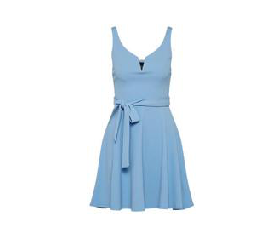

SHAPE MODIFICATION
--------------------
Choose from the following: ['sleeve_length', 'fit', 'neckline', 'length']
or press ENTER to skip


In [ ]:
best_img = GAN_search(test_img)